In [1]:
import numpy as np
from scipy.special import gammainc, gamma
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.integrate import quad
from scipy.stats import poisson
from tqdm import tqdm   
from random import choices
from collections import Counter

In [14]:
recordTime = .003
rateSingleAtom = 145000
rateBackground = 10000
lifetimeOfTrap = 1000000


countEnd = 700
xx = np.arange(countEnd)
probDistBack = poisson.pmf(xx,recordTime*rateBackground)
def singleAtom(recordTime,rate,lifeTime,xx):
    prob = []
    for i in tqdm(xx):
        val = quad(lambda t,r,n,ts,tau:np.exp(-t/tau)/tau*poisson.pmf(n,r*t)+np.exp(-ts/tau)*poisson.pmf(n,r*ts),
        0,recordTime, args = (rate,i,recordTime, lifeTime) )[0] 
        prob.append(val)
    return prob





In [15]:
probDistSingle = singleAtom(recordTime,rateSingleAtom,lifetimeOfTrap,xx)


100%|██████████| 700/700 [00:08<00:00, 81.78it/s]


In [16]:
hist = [] 
N = 5000
population = [0,1]
weights = [.5,.5]
samples = choices(population,weights,k = N)

for i in samples:
    if i == 0:
        #do background rate

        hist.append(choices(xx,probDistSingle)[0])
    else:
        #do single atom rate
        hist.append(choices(xx,probDistBack)[0])

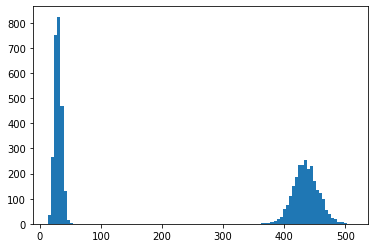

In [17]:
plt.hist(hist,100)
plt.show()